In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [17]:
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest = dt.datetime.strptime(latest[0], '%Y-%m-%d')
year_earlier = latest - dt.timedelta(days=366)

prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_earlier).all()

prcp_dict_list = []
for result in prcp_query:
    row = {}
    row["date"] = result[0]
    row["prcp"] = result[1]
    prcp_dict_list.append(row)
type(prcp_dict_list[0]['prcp'])
dict(prcp_query)

{'2016-08-23': 0.7,
 '2016-08-24': 1.45,
 '2016-08-25': 0.11,
 '2016-08-26': 0.01,
 '2016-08-27': None,
 '2016-08-28': 2.07,
 '2016-08-29': 0.9,
 '2016-08-30': 0.05,
 '2016-08-31': 2.46,
 '2016-09-01': 0.01,
 '2016-09-02': 0.03,
 '2016-09-03': 1.0,
 '2016-09-04': 0.44,
 '2016-09-05': 0.18,
 '2016-09-06': 1.0,
 '2016-09-07': 1.35,
 '2016-09-08': 0.15,
 '2016-09-09': 0.35,
 '2016-09-10': 1.16,
 '2016-09-11': 0.6,
 '2016-09-12': 1.04,
 '2016-09-13': 1.2,
 '2016-09-14': 6.7,
 '2016-09-15': 3.35,
 '2016-09-16': 0.61,
 '2016-09-17': 0.23,
 '2016-09-18': 0.42,
 '2016-09-19': 0.25,
 '2016-09-20': 0.43,
 '2016-09-21': 1.02,
 '2016-09-22': 0.75,
 '2016-09-23': 0.33,
 '2016-09-24': 0.27,
 '2016-09-25': 0.04,
 '2016-09-26': 1.02,
 '2016-09-27': 1.0,
 '2016-09-28': 0.05,
 '2016-09-29': 1.49,
 '2016-09-30': 0.38,
 '2016-10-01': 1.02,
 '2016-10-02': 0.61,
 '2016-10-03': 0.46,
 '2016-10-04': 3.46,
 '2016-10-05': 0.81,
 '2016-10-06': 0.04,
 '2016-10-07': 0.01,
 '2016-10-08': 0.04,
 '2016-10-09': 0.0,
 

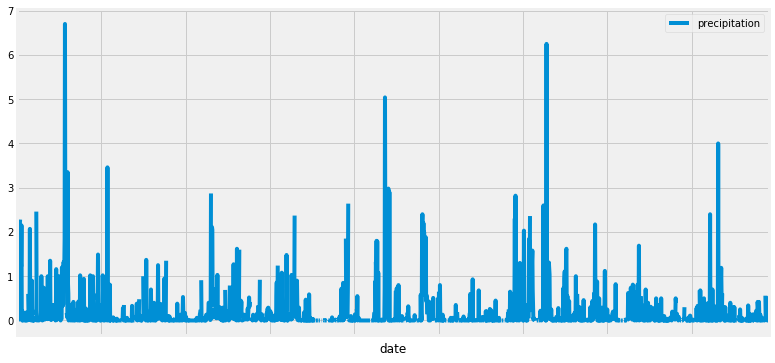

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest = dt.datetime.strptime(latest[0], '%Y-%m-%d')
year_earlier = latest - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
year_of_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_earlier).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_of_data_df = pd.DataFrame(year_of_data, columns=['date', 'precipitation'])
year_of_data_df.set_index('date', inplace=True)

# Sort the dataframe by date
year_of_data_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12,6))
year_of_data_df.plot(ax=ax)
ax.set_xticklabels([""])
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_of_data_df.describe()
#missing 7 data points (count=2015) when i used number of days as 365, so changed to 366
#to match provided expected output, plus 2016 was leap year

#alternatively, simply pick 8/23/16 after seeing lastest date is 8/23/17

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()
# there are 9 stations

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity = session.query(Measurement.station ,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = activity[0][0] #Most active is ('USC00519281', 2772)
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Choose the station with the highest number of temperature observations.
#should be same as most_active_station....and it is
session.query(Measurement.station ,func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

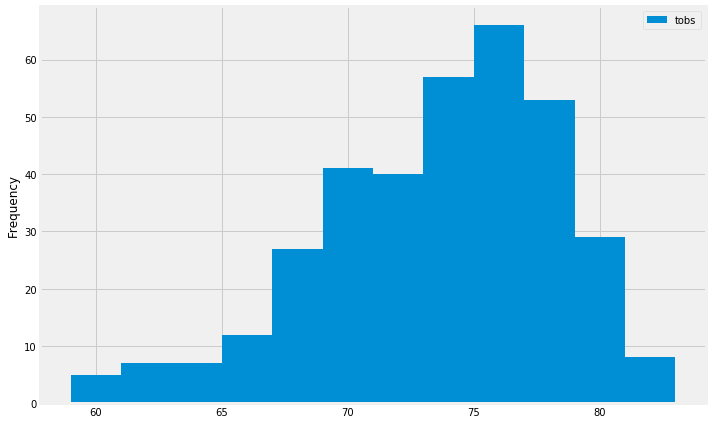

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_of_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_earlier).\
    filter(Measurement.station == most_active_station).all()
fig, ax = plt.subplots(figsize=(10,6))
ax.hist([x[0] for x in year_of_temp], bins=12, label='tobs')
ax.legend()
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#this section doesnt appear to be in the readme on the homework page
#oh well, pretend I will go around my birthday 3/15/20 for 7 days
#so, 2017-03-15 to 2017-03-22 
start_date = '2017-03-15'
end_date = '2017-03-22'
my_bday_trip = calc_temps(start_date, end_date)
print(my_bday_trip)
#seems pleasant

[(65.0, 72.33333333333333, 77.0)]


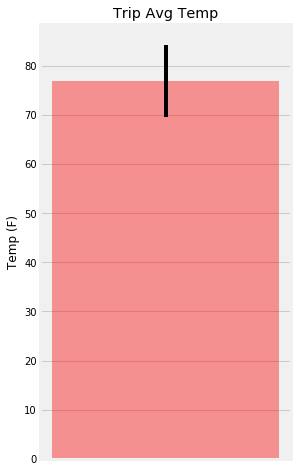

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize = (4, 8))
ax.bar(x=1,height=my_bday_trip[0][2], width=0.3,\
       yerr=(my_bday_trip[0][1] - my_bday_trip[0][0]), color='red', alpha=0.4)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
ax.set_xticks([])
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude,\
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
print('(station, name, latitude, longitude, elevation, total rainfall)')

for row in session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date.between(start_date, end_date)).group_by(Station.station).\
        order_by(func.sum(Measurement.prcp).desc()).all():
    print(row)

(station, name, latitude, longitude, elevation, total rainfall)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.35)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.29)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.19)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
